# Task 1.3: Time Series Properties Analysis

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

In [11]:
# Load and prepare data
df = pd.read_csv('../../data/raw/BrentOilPrices.csv')

def parse_date(date_str):
    try:
        if '-' in date_str:
            return pd.to_datetime(date_str, format='%d-%b-%y')
        else:
            return pd.to_datetime(date_str, format='%b %d, %Y')
    except:
        return pd.NaT

df['Date'] = df['Date'].apply(parse_date)
df = df.dropna(subset=['Date']).sort_values('Date').reset_index(drop=True)
df.set_index('Date', inplace=True)

print(f"Data period: {df.index.min()} to {df.index.max()}")
print(f"Total observations: {len(df)}")
print(f"Price range: ${df['Price'].min():.2f} to ${df['Price'].max():.2f}")

Data period: 1987-05-20 00:00:00 to 2022-11-14 00:00:00
Total observations: 9011
Price range: $9.10 to $143.95


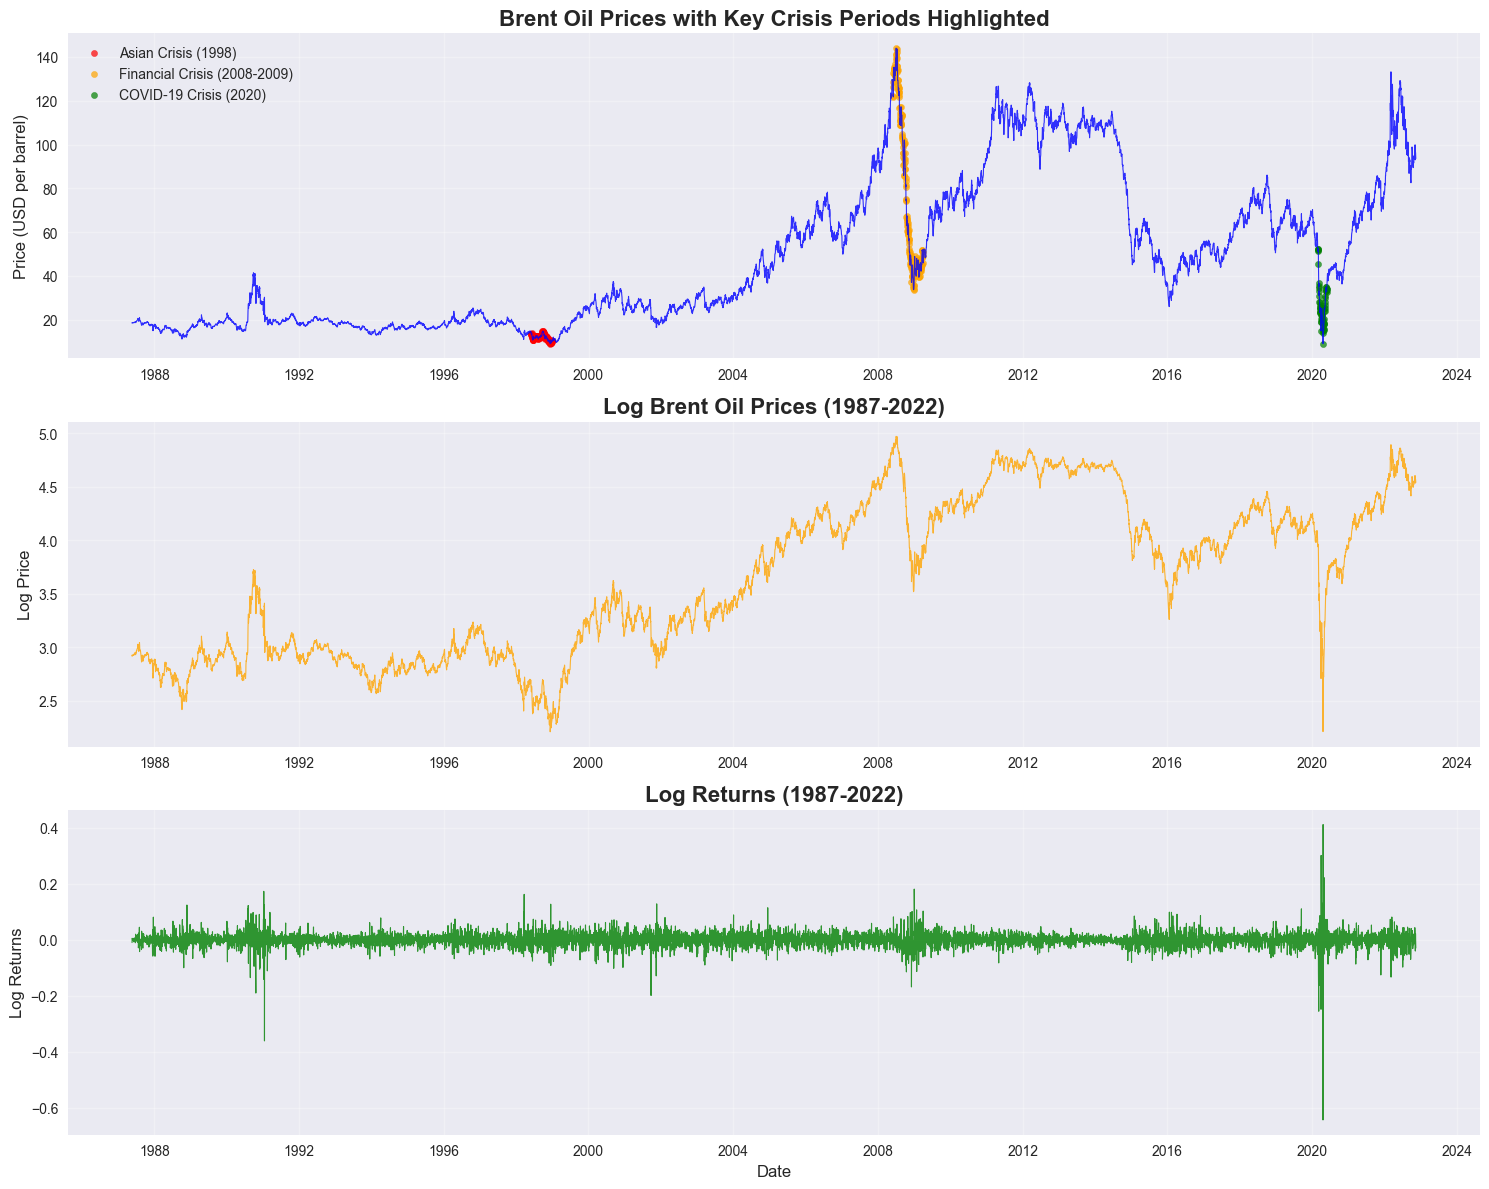

In [12]:
# Time series visualization
plt.figure(figsize=(15, 12))

plt.subplot(3, 1, 1)
plt.plot(df.index, df['Price'], linewidth=0.8, alpha=0.8, color='blue')

asian_crisis = df[(df.index >= '1998-06-01') & (df.index <= '1998-12-31')]
financial_crisis = df[(df.index >= '2008-06-01') & (df.index <= '2009-03-31')]
covid_crisis = df[(df.index >= '2020-03-01') & (df.index <= '2020-05-31')]

plt.scatter(asian_crisis.index, asian_crisis['Price'], 
           color='red', s=20, alpha=0.7, label='Asian Crisis (1998)')
plt.scatter(financial_crisis.index, financial_crisis['Price'], 
           color='orange', s=20, alpha=0.7, label='Financial Crisis (2008-2009)')
plt.scatter(covid_crisis.index, covid_crisis['Price'], 
           color='green', s=20, alpha=0.7, label='COVID-19 Crisis (2020)')

plt.title('Brent Oil Prices with Key Crisis Periods Highlighted', fontsize=16, fontweight='bold')
plt.ylabel('Price (USD per barrel)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(3, 1, 2)
plt.plot(df.index, np.log(df['Price']), linewidth=0.8, alpha=0.8, color='orange')
plt.title('Log Brent Oil Prices (1987-2022)', fontsize=16, fontweight='bold')
plt.ylabel('Log Price', fontsize=12)
plt.grid(True, alpha=0.3)

log_returns = np.log(df['Price'] / df['Price'].shift(1))
plt.subplot(3, 1, 3)
plt.plot(df.index, log_returns, linewidth=0.8, alpha=0.8, color='green')
plt.title('Log Returns (1987-2022)', fontsize=16, fontweight='bold')
plt.ylabel('Log Returns', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [13]:
# Stationarity tests
def test_stationarity(timeseries, title):
    adf_result = adfuller(timeseries.dropna())
    kpss_result = kpss(timeseries.dropna())
    
    print(f"{title}:")
    print(f"ADF p-value: {adf_result[1]:.4f}")
    print(f"KPSS p-value: {kpss_result[1]:.4f}")
    
    return {
        'adf_pvalue': adf_result[1],
        'kpss_pvalue': kpss_result[1]
    }

original_results = test_stationarity(df['Price'], "Original Prices")
log_results = test_stationarity(np.log(df['Price']), "Log Prices")
diff_results = test_stationarity(df['Price'].diff().dropna(), "First Differences")
returns_results = test_stationarity(log_returns.dropna(), "Log Returns")

Original Prices:
ADF p-value: 0.2893
KPSS p-value: 0.0100
Log Prices:
ADF p-value: 0.3761
KPSS p-value: 0.0100
First Differences:
ADF p-value: 0.0000
KPSS p-value: 0.1000
Log Returns:
ADF p-value: 0.0000
KPSS p-value: 0.1000


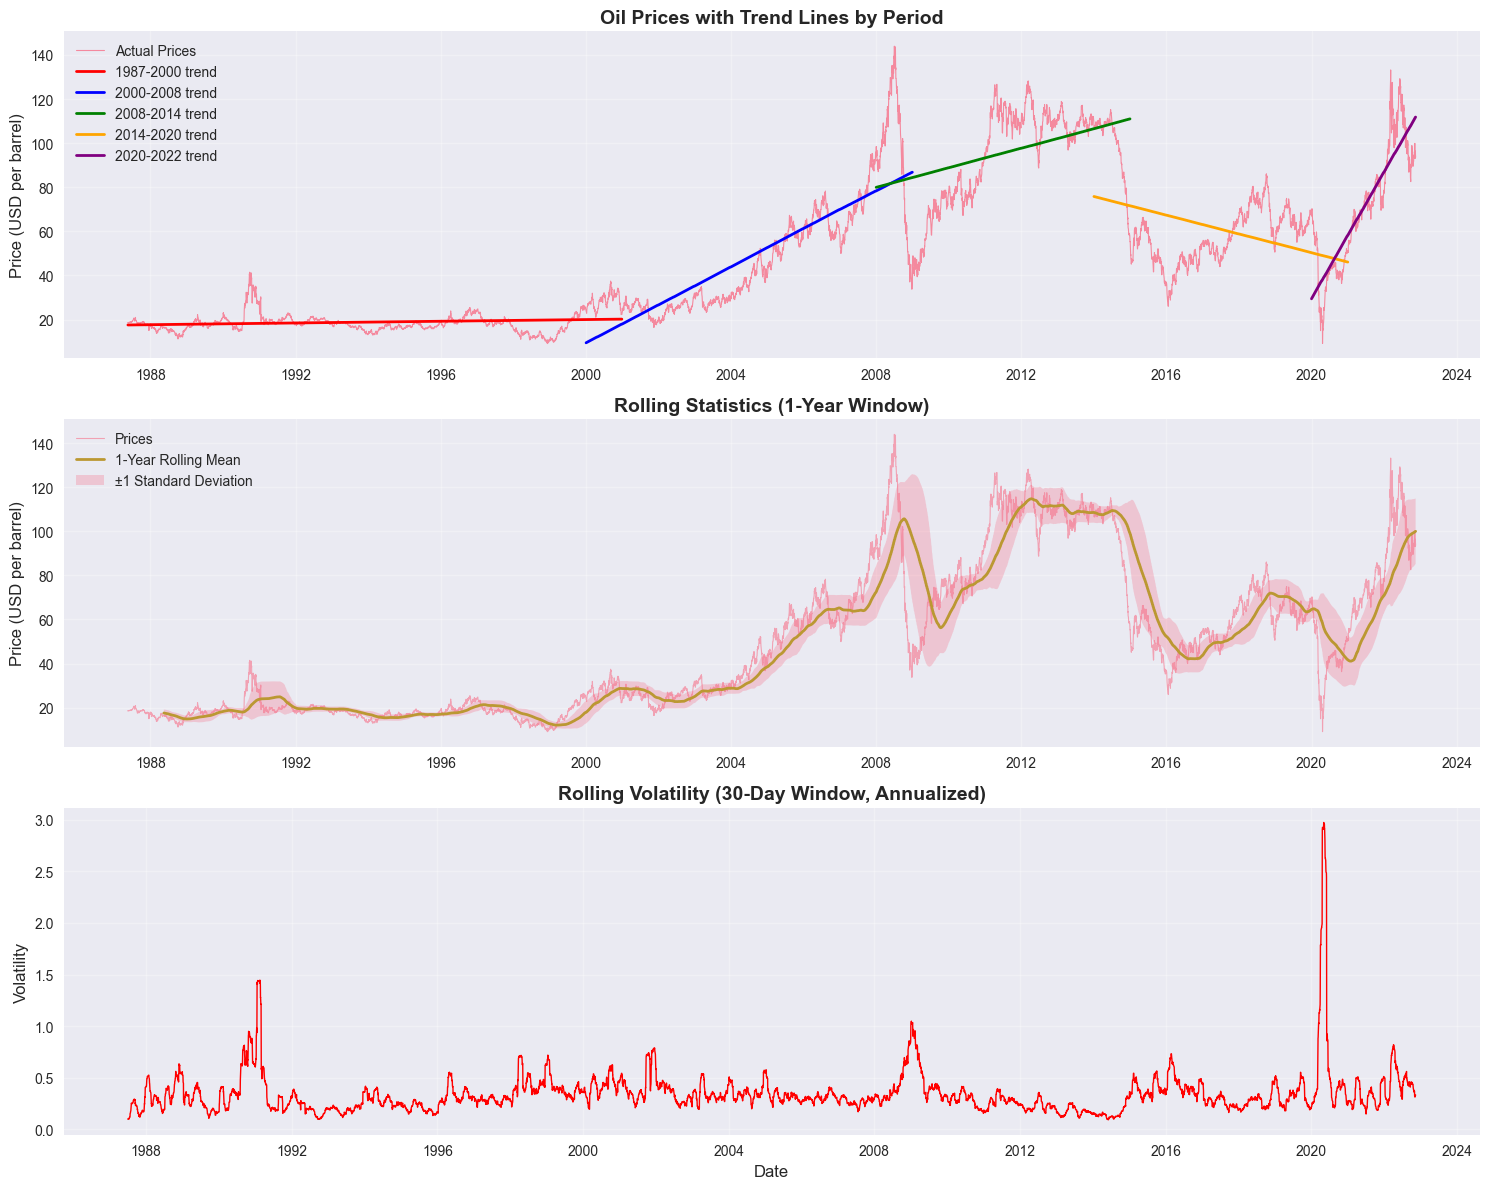

In [14]:
# Trend analysis
plt.figure(figsize=(15, 12))

plt.subplot(3, 1, 1)
plt.plot(df.index, df['Price'], linewidth=0.8, alpha=0.8, label='Actual Prices')

periods = [
    ('1987-2000', '1987-01-01', '2000-12-31'),
    ('2000-2008', '2000-01-01', '2008-12-31'),
    ('2008-2014', '2008-01-01', '2014-12-31'),
    ('2014-2020', '2014-01-01', '2020-12-31'),
    ('2020-2022', '2020-01-01', '2022-12-31')
]

colors = ['red', 'blue', 'green', 'orange', 'purple']
for i, (period_name, start_date, end_date) in enumerate(periods):
    period_data = df[(df.index >= start_date) & (df.index <= end_date)]
    if len(period_data) > 0:
        x = np.arange(len(period_data))
        z = np.polyfit(x, period_data['Price'], 1)
        p = np.poly1d(z)
        plt.plot(period_data.index, p(x), color=colors[i], linewidth=2, 
                label=f'{period_name} trend')

plt.title('Oil Prices with Trend Lines by Period', fontsize=14, fontweight='bold')
plt.ylabel('Price (USD per barrel)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(3, 1, 2)
rolling_mean = df['Price'].rolling(window=252).mean()
rolling_std = df['Price'].rolling(window=252).std()
plt.plot(df.index, df['Price'], linewidth=0.8, alpha=0.6, label='Prices')
plt.plot(df.index, rolling_mean, linewidth=2, label='1-Year Rolling Mean')
plt.fill_between(df.index, rolling_mean - rolling_std, rolling_mean + rolling_std, 
                alpha=0.3, label='±1 Standard Deviation')
plt.title('Rolling Statistics (1-Year Window)', fontsize=14, fontweight='bold')
plt.ylabel('Price (USD per barrel)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(3, 1, 3)
rolling_vol = log_returns.rolling(window=30).std() * np.sqrt(252)
rolling_vol_aligned = rolling_vol.reindex(df.index)
plt.plot(df.index, rolling_vol_aligned, linewidth=1, color='red')
plt.title('Rolling Volatility (30-Day Window, Annualized)', fontsize=14, fontweight='bold')
plt.ylabel('Volatility', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

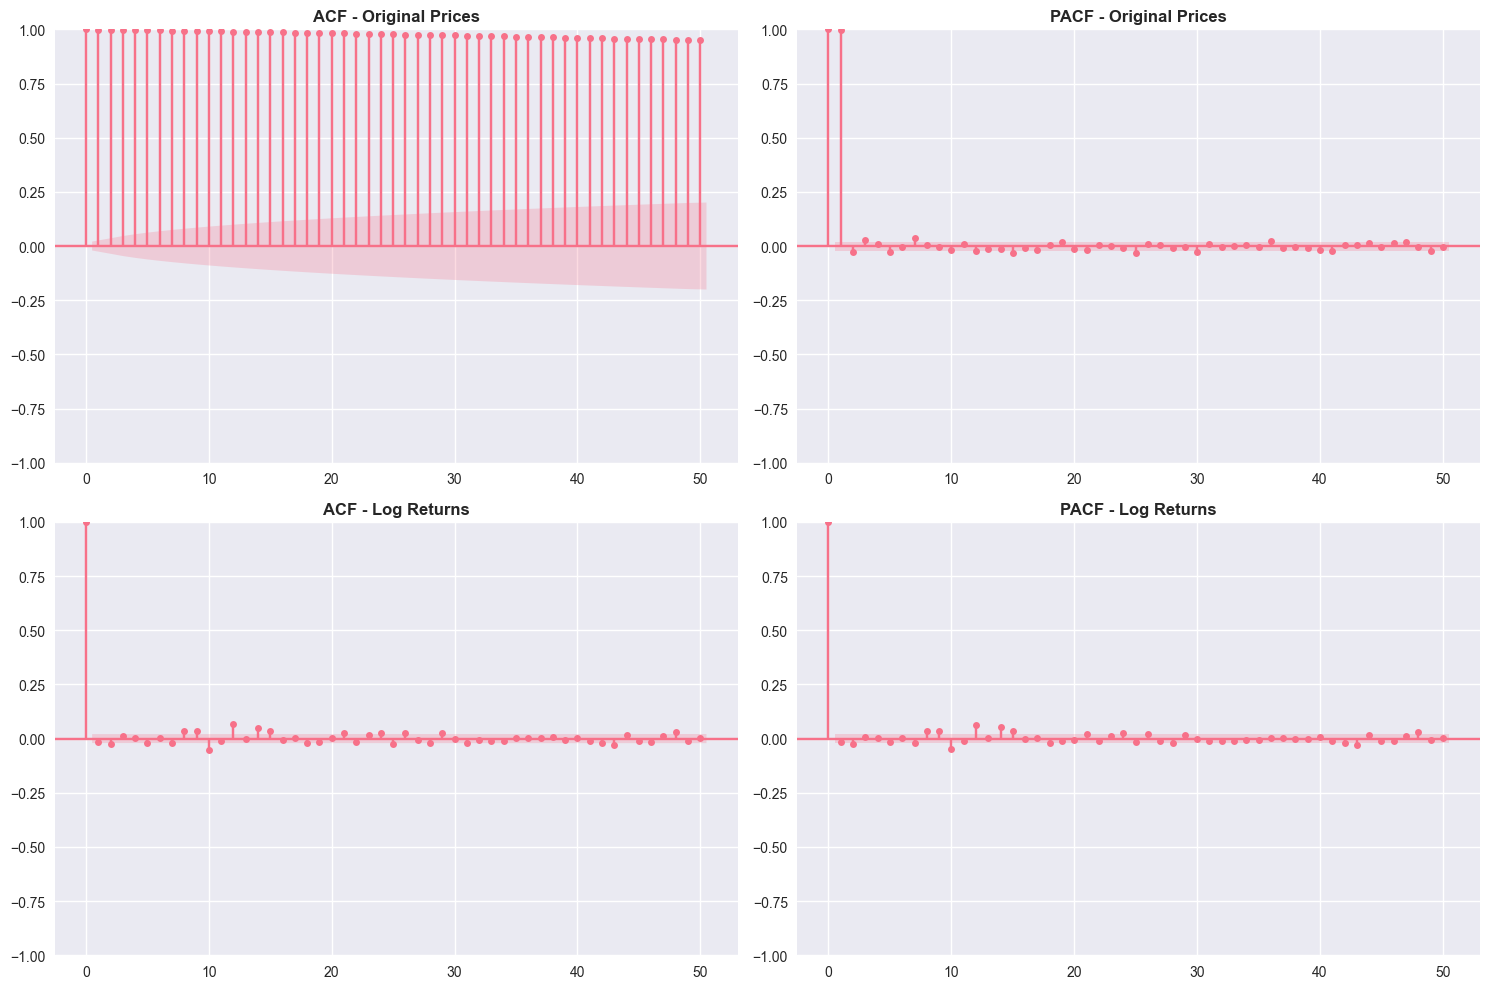

In [15]:
# Autocorrelation analysis
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plot_acf(df['Price'].dropna(), lags=50, alpha=0.05, ax=plt.gca())
plt.title('ACF - Original Prices', fontsize=12, fontweight='bold')

plt.subplot(2, 2, 2)
plot_pacf(df['Price'].dropna(), lags=50, alpha=0.05, ax=plt.gca())
plt.title('PACF - Original Prices', fontsize=12, fontweight='bold')

plt.subplot(2, 2, 3)
plot_acf(log_returns.dropna(), lags=50, alpha=0.05, ax=plt.gca())
plt.title('ACF - Log Returns', fontsize=12, fontweight='bold')

plt.subplot(2, 2, 4)
plot_pacf(log_returns.dropna(), lags=50, alpha=0.05, ax=plt.gca())
plt.title('PACF - Log Returns', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

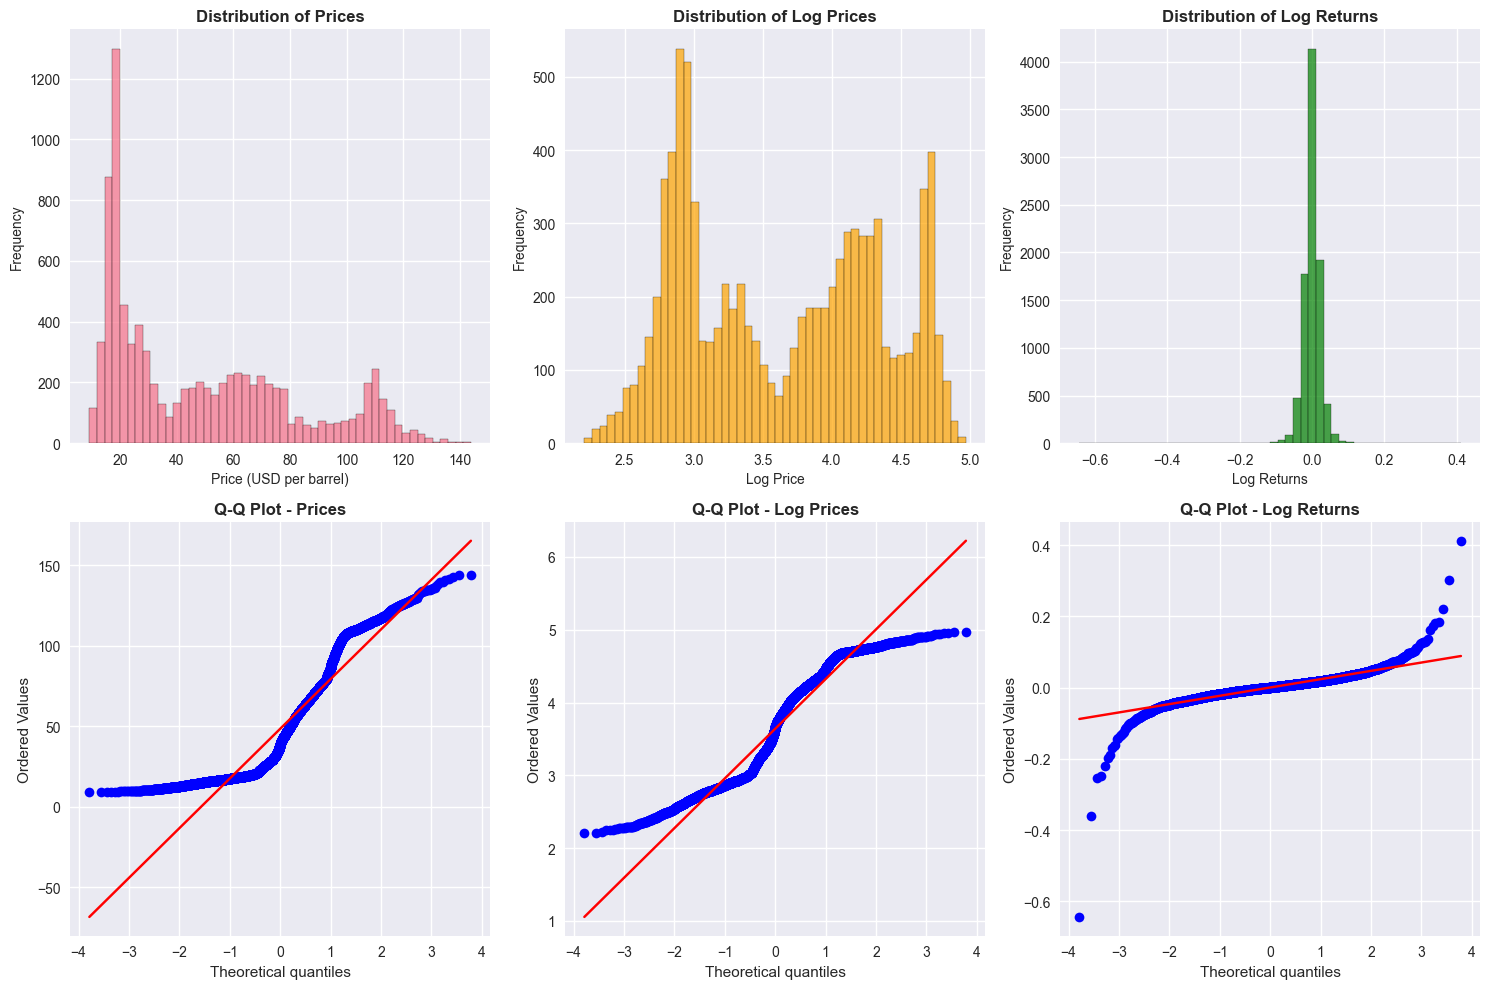

In [16]:
# Distribution analysis
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.hist(df['Price'], bins=50, alpha=0.7, edgecolor='black')
plt.title('Distribution of Prices', fontsize=12, fontweight='bold')
plt.xlabel('Price (USD per barrel)', fontsize=10)
plt.ylabel('Frequency', fontsize=10)

plt.subplot(2, 3, 2)
plt.hist(np.log(df['Price']), bins=50, alpha=0.7, edgecolor='black', color='orange')
plt.title('Distribution of Log Prices', fontsize=12, fontweight='bold')
plt.xlabel('Log Price', fontsize=10)
plt.ylabel('Frequency', fontsize=10)

plt.subplot(2, 3, 3)
plt.hist(log_returns.dropna(), bins=50, alpha=0.7, edgecolor='black', color='green')
plt.title('Distribution of Log Returns', fontsize=12, fontweight='bold')
plt.xlabel('Log Returns', fontsize=10)
plt.ylabel('Frequency', fontsize=10)

plt.subplot(2, 3, 4)
stats.probplot(df['Price'], dist="norm", plot=plt)
plt.title('Q-Q Plot - Prices', fontsize=12, fontweight='bold')

plt.subplot(2, 3, 5)
stats.probplot(np.log(df['Price']), dist="norm", plot=plt)
plt.title('Q-Q Plot - Log Prices', fontsize=12, fontweight='bold')

plt.subplot(2, 3, 6)
stats.probplot(log_returns.dropna(), dist="norm", plot=plt)
plt.title('Q-Q Plot - Log Returns', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

                              mean_price  std_price  mean_return  std_return  \
Asian Crisis (1998)              11.8926     1.2865      -0.0017      0.0301   
Financial Crisis (2008-2009)     77.8870    36.7122      -0.0049      0.0420   
COVID-19 Crisis (2020)           26.8870     9.7183      -0.0072      0.1423   
Normal Period (2019)             64.3198     4.3666       0.0009      0.0204   

                              volatility  min_price  max_price  
Asian Crisis (1998)               0.4773       9.10      14.84  
Financial Crisis (2008-2009)      0.6672      33.73     143.95  
COVID-19 Crisis (2020)            2.2585       9.12      52.52  
Normal Period (2019)              0.3243      53.23      74.94  


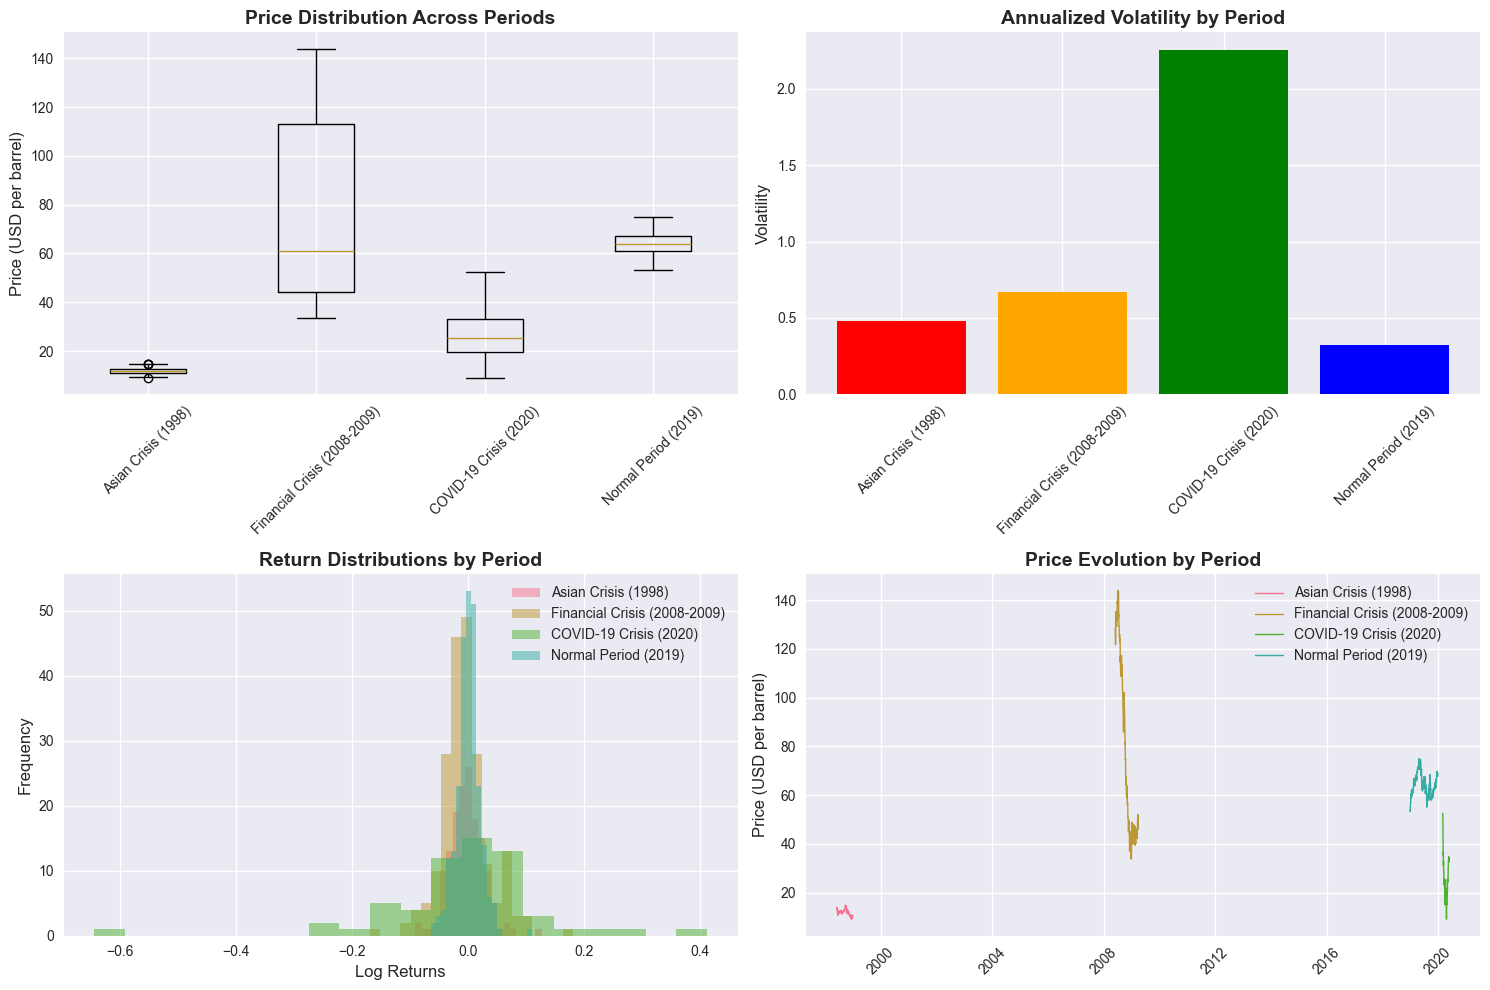

In [17]:
# Crisis period analysis
crisis_periods = {
    'Asian Crisis (1998)': ('1998-06-01', '1998-12-31'),
    'Financial Crisis (2008-2009)': ('2008-06-01', '2009-03-31'),
    'COVID-19 Crisis (2020)': ('2020-03-01', '2020-05-31'),
    'Normal Period (2019)': ('2019-01-01', '2019-12-31')
}

crisis_stats = {}
for period_name, (start_date, end_date) in crisis_periods.items():
    period_data = df[(df.index >= start_date) & (df.index <= end_date)]
    if len(period_data) > 0:
        period_returns = np.log(period_data['Price'] / period_data['Price'].shift(1)).dropna()
        
        crisis_stats[period_name] = {
            'mean_price': period_data['Price'].mean(),
            'std_price': period_data['Price'].std(),
            'mean_return': period_returns.mean(),
            'std_return': period_returns.std(),
            'volatility': period_returns.std() * np.sqrt(252),
            'min_price': period_data['Price'].min(),
            'max_price': period_data['Price'].max()
        }

crisis_df = pd.DataFrame(crisis_stats).T
print(crisis_df.round(4))

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
crisis_data = {}
for period_name, (start_date, end_date) in crisis_periods.items():
    period_data = df[(df.index >= start_date) & (df.index <= end_date)]
    if len(period_data) > 0:
        crisis_data[period_name] = period_data['Price'].values

plt.boxplot(crisis_data.values(), labels=crisis_data.keys())
plt.title('Price Distribution Across Periods', fontsize=14, fontweight='bold')
plt.ylabel('Price (USD per barrel)', fontsize=12)
plt.xticks(rotation=45)

plt.subplot(2, 2, 2)
volatilities = [crisis_stats[period]['volatility'] for period in crisis_stats.keys()]
plt.bar(crisis_stats.keys(), volatilities, color=['red', 'orange', 'green', 'blue'])
plt.title('Annualized Volatility by Period', fontsize=14, fontweight='bold')
plt.ylabel('Volatility', fontsize=12)
plt.xticks(rotation=45)

plt.subplot(2, 2, 3)
for period_name, (start_date, end_date) in crisis_periods.items():
    period_data = df[(df.index >= start_date) & (df.index <= end_date)]
    if len(period_data) > 0:
        period_returns = np.log(period_data['Price'] / period_data['Price'].shift(1)).dropna()
        plt.hist(period_returns, bins=20, alpha=0.5, label=period_name)

plt.title('Return Distributions by Period', fontsize=14, fontweight='bold')
plt.xlabel('Log Returns', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()

plt.subplot(2, 2, 4)
for period_name, (start_date, end_date) in crisis_periods.items():
    period_data = df[(df.index >= start_date) & (df.index <= end_date)]
    if len(period_data) > 0:
        plt.plot(period_data.index, period_data['Price'], label=period_name, linewidth=1)

plt.title('Price Evolution by Period', fontsize=14, fontweight='bold')
plt.ylabel('Price (USD per barrel)', fontsize=12)
plt.legend()
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()